<a href="https://colab.research.google.com/github/anampavicic/SGAI-Final-Project/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!unzip /content/history.zip -d //content/


Archive:  /content/history.zip
  inflating: //content/history/Aalborg.txt  
  inflating: //content/history/Aarhus.txt  
  inflating: //content/history/Aasiaat.txt  
  inflating: //content/history/Abadan.txt  
  inflating: //content/history/Abakan.txt  
  inflating: //content/history/Aberdeen.txt  
  inflating: //content/history/Abha.txt  
  inflating: //content/history/Abidjan.txt  
  inflating: //content/history/Abu Dhabi.txt  
  inflating: //content/history/Abu Simbel.txt  
  inflating: //content/history/Abuja.txt  
  inflating: //content/history/Acapulco.txt  
  inflating: //content/history/Accra.txt  
  inflating: //content/history/Adak Island.txt  
  inflating: //content/history/Adana.txt  
  inflating: //content/history/Addis Ababa.txt  
  inflating: //content/history/Adelaide.txt  
  inflating: //content/history/Aden.txt  
  inflating: //content/history/Adiyaman.txt  
  inflating: //content/history/Agadir.txt  
  inflating: //content/history/Agana.txt  
  inflating: //content/hi

In [5]:
import pickle
with open('graph_with_content.pickle', 'rb') as f:
   G_loaded = pickle.load(f)
print(len(G_loaded.edges()))

26808


In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf
import polars as pl
import os
import pandas as pd
import numpy as np

In [7]:
def get_transformers_word_embeddings(model: AutoModel):
    return model.embeddings.word_embeddings.weight.data.to("cpu").numpy()

def generate_embeddings_with_transformers(
    model: AutoModel,
    tokenizer: AutoTokenizer,
    text_list: list[str],
    batch_size: int = 8,
    device: str = None,
    disable_tqdm: bool = False,
) -> torch.Tensor:
    """
    Generates embeddings for a list of texts using a pre-trained transformer model.

    Args:
        model_name (str): The name of the pre-trained transformer model to use.
        text_list (list of str): A list of texts to generate embeddings for.
        batch_size (int): The batch size to use for generating embeddings. Defaults to 8.
        device (str): The device to use for generating embeddings (e.g., "cpu", "cuda").
            If None, defaults to the first available GPU or CPU.

    Returns:
        embeddings (torch.Tensor): A tensor containing the embeddings for the input texts.
            The shape of the tensor is (num_texts, embedding_dim), where num_texts is the number
            of input texts and embedding_dim is the dimensionality of the embeddings produced by
            the pre-trained model.

    Examples:
    >>> model_name = "bert-base-uncased"
    >>> text_list = ["hello world", "how are you"]
    >>> batch_size = 2
    >>> device = "cpu"
    >>> model = AutoModel.from_pretrained(model_name)
    >>> tokenizer = AutoTokenizer.from_pretrained(model_name)
    >>> embeddings_tensor = generate_embeddings_with_transformers(model, tokenizer, text_list, batch_size, device)
    >>> print(embeddings_tensor)
        tensor([[-0.0243,  0.1144,  0.0830,  ..., -0.2666,  0.1662,  0.1519],
                [ 0.0827,  0.0877, -0.0688,  ..., -0.4381,  0.0462, -0.1446]])
    >>> print(embeddings_tensor.shape)
        torch.Size([2, 768])
    """
    device = get_torch_device(use_gpu=True) if device is None else device
    model = model.to(device)

    tokenized_text = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    feature_names = list(tokenized_text)

    dataset = TensorDataset(
        tokenized_text["input_ids"], tokenized_text["attention_mask"]
    )
    dataloader = DataLoader(dataset, batch_size=batch_size)
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Encoding", disable=disable_tqdm):
            inputs = {feat: t.to(device) for feat, t in zip(feature_names, batch)}
            outputs = model(
                **inputs,
                output_hidden_states=True,
            )
            embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze(dim=1))
    return torch.vstack(embeddings)


def convert_text2encoding_with_transformers(
    df: pl.DataFrame,
    tokenizer: AutoTokenizer,
    column: str,
    max_length: int = 512,
) -> pl.DataFrame:
    """Converts text in a specified DataFrame column to tokens using a provided tokenizer.
    Args:
        df (pl.DataFrame): The input DataFrame containing the text column.
        tokenizer (AutoTokenizer): The tokenizer to use for encoding the text. (from transformers import AutoTokenizer)
        column (str): The name of the column containing the text.
        max_length (int, optional): The maximum length of the encoded tokens. Defaults to None.
    Returns:
        pl.DataFrame: A new DataFrame with an additional column containing the encoded tokens.
    Example:
    >>> from transformers import AutoTokenizer
    >>> import polars as pl
    >>> df = pl.DataFrame({
            'text': ['This is a test.', 'Another test string.', 'Yet another one.']
        })
    >>> tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    >>> encoded_df, new_column = convert_text2encoding_with_transformers(df, tokenizer, 'text', max_length=20)
    >>> print(encoded_df)
        shape: (3, 2)
        ┌──────────────────────┬───────────────────────────────┐
        │ text                 ┆ text_encode_bert-base-uncased │
        │ ---                  ┆ ---                           │
        │ str                  ┆ list[i64]                     │
        ╞══════════════════════╪═══════════════════════════════╡
        │ This is a test.      ┆ [2023, 2003, … 0]             │
        │ Another test string. ┆ [2178, 3231, … 0]             │
        │ Yet another one.     ┆ [2664, 2178, … 0]             │
        └──────────────────────┴───────────────────────────────┘
    >>> print(new_column)
        text_encode_bert-base-uncased
    """
    text = df[column].to_list()
    # set columns
    new_column = f"{column}_encode_{tokenizer.name_or_path}"
    # If 'max_length' is provided then set it, else encode each string its original length
    padding = "max_length" if max_length else False
    encoded_tokens = tokenizer(
        text,
        add_special_tokens=False,
        padding=padding,
        max_length=max_length,
        truncation=True,
    )["input_ids"]
    return df.with_columns(pl.Series(new_column, encoded_tokens)), new_column

def concat_str_columns(df: pl.DataFrame, columns: list[str]) -> pl.DataFrame:
    """
    >>> df = pl.DataFrame(
            {
                "id": [1, 2, 3],
                "first_name": ["John", "Jane", "Alice"],
                "last_name": ["Doe", "Doe", "Smith"],
            }
        )
    >>> concatenated_df, concatenated_column_name = concat_str_columns(df, columns=['first_name', 'last_name'])
    >>> concatenated_df
        shape: (3, 4)
        ┌─────┬────────────┬───────────┬──────────────────────┐
        │ id  ┆ first_name ┆ last_name ┆ first_name-last_name │
        │ --- ┆ ---        ┆ ---       ┆ ---                  │
        │ i64 ┆ str        ┆ str       ┆ str                  │
        ╞═════╪════════════╪═══════════╪══════════════════════╡
        │ 1   ┆ John       ┆ Doe       ┆ John Doe             │
        │ 2   ┆ Jane       ┆ Doe       ┆ Jane Doe             │
        │ 3   ┆ Alice      ┆ Smith     ┆ Alice Smith          │
        └─────┴────────────┴───────────┴──────────────────────┘
    """
    concat_name = "-".join(columns)
    concat_columns = df.select(pl.concat_str(columns, separator=" ").alias(concat_name))
    return df.with_columns(concat_columns), concat_name


In [8]:
print(G_loaded.nodes())

['Sochi', 'Kazan', 'Astrakhan', 'Mineralnye Vody', 'Chelyabinsk', 'Novosibirsk', 'Moscow', 'Taganrog', 'Belgorod', 'Kaliningrad', 'Baku', 'St. Petersburg', 'Yekaterinburg', 'Nizhnevartovsk', 'Novy Urengoy', 'Bratsk', 'Irkutsk', 'Kirensk', 'Bodaibo', 'Ust-Kut', 'Lensk', 'Yakutsk', 'Ayacucho', 'Lima', 'Cuzco', 'Puerto Maldonado', 'Huánuco', 'Iquitos', 'Pucallpa', 'Tarapoto', 'Abidjan', 'Ouagadougou', 'Accra', 'Bamako', 'Dakar', 'Cotonou', 'Lome', 'Niamey', 'Bogota', 'Guayaquil', 'Quito', 'Cali', 'Coca', 'Brindisi', 'Zurich', 'Bordeaux', 'Bristol', 'Geneva', 'Gran Canaria', 'Larnaca', 'Marsa Alam', 'Tenerife', 'Arvidsjaur', 'Lycksele', 'Stockholm', 'Gallivare', 'Halmstad', 'Joenkoeping', 'Karlstad', 'Mariehamn', 'Ornskoldsvik', 'Pori', 'Sandefjord', 'Visby', 'Vilhelmina', 'Vaxjo', 'Hemavan', 'Kruunupyy', 'Turku', 'Oslo', 'Larsen Bay', 'Manila', 'Butuan', 'Cotabato', 'Cagayan de Oro City', 'Dumaguete', 'Dubai', 'Romblon', 'Kalibo', 'Caticlan', 'Ozamis', 'Puerto Princesa', 'Roxas City', 'Sa

In [9]:
#go through every file in history folder
text_df = pl.DataFrame({"node": pl.Series([], dtype=pl.Utf8), "content": pl.Series([], dtype=pl.Utf8)})

for filename in os.listdir('history'):
    #save to dataframe node name in one column and content in another
    filename_wo_txt = filename.split('.')[0]
    #check if node is in graph
    if filename_wo_txt in G_loaded.nodes():
        with open(os.path.join('history', filename), 'r', encoding='utf-8') as file:
            content = file.read()
        #add content to dataframe
        new_row = pl.DataFrame({"node": [filename_wo_txt], "content": [content]})
        text_df = pl.concat([text_df, new_row], how="vertical", rechunk=True)




In [77]:
#remove empty content
text_df = text_df.filter(pl.col("content") != "")

In [78]:
text_df

node,content
str,str
"""Whitehorse""","""Archaeological research south …"
"""Dijon""","""The earliest archaeological fi…"
"""Bhubaneswar""","""Bhubaneswar stands near the ru…"
"""Paris""","""===Origins=== The ''Parisii (…"
"""Dire Dawa""","""=== Origins === The region w…"
…,…
"""Kenora""","""Kenora is situated on the trad…"
"""Lansdowne House""","""It was designed by Robert Adam…"
"""Kostanay""","""Kostanay was founded by Russia…"


# Transformers

In [88]:
TRANSFORMER_MODEL_NAME = "dslim/bert-base-NER"
TEXT_COLUMNS_TO_USE = ['content']

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, token_col_title = convert_text2encoding_with_transformers(text_df, transformer_tokenizer, TEXT_COLUMNS_TO_USE[0])

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [89]:
df_articles

node,content,content_encode_dslim/bert-base-NER
str,str,list[i64]
"""Whitehorse""","""Archaeological research south …","[17249, 1844, … 3441]"
"""Dijon""","""The earliest archaeological fi…","[1109, 5041, … 118]"
"""Bhubaneswar""","""Bhubaneswar stands near the ru…","[139, 6583, … 0]"
"""Paris""","""===Origins=== The ''Parisii (…","[134, 134, … 2226]"
"""Dire Dawa""","""=== Origins === The region w…","[134, 134, … 1113]"
…,…,…
"""Kenora""","""Kenora is situated on the trad…","[5928, 6533, … 15171]"
"""Lansdowne House""","""It was designed by Robert Adam…","[1135, 1108, … 0]"
"""Kostanay""","""Kostanay was founded by Russia…","[19892, 13946, … 0]"


In [90]:
from sklearn.metrics.pairwise import cosine_similarity

cities = df_articles['node'].to_list()
embeddings = np.vstack(df_articles[token_col_title].to_list())

# Compute the cosine similarity matrix
cosine_similarities = cosine_similarity(embeddings)

# Put in a dataframe
cosine_similarities_df = pd.DataFrame(cosine_similarities, index=cities, columns=cities)

In [91]:
cosine_similarities_df

,Whitehorse,Dijon,Bhubaneswar,Paris,Dire Dawa,Ubon Ratchathani,Rahim Yar Khan,Biratnagar,Point Barrow,Mexico City,...,Libreville,Ornskoldsvik,Bratsk,Bilbao,Koumac,Kenora,Lansdowne House,Kostanay,Chumphon,Tanjung Pinang
Whitehorse,1.000000,0.349144,0.383136,0.264592,0.330431,0.259299,0.233734,0.306238,0.258541,0.324077,...,0.296412,0.244054,0.324596,0.308164,0.170247,0.302376,0.363818,0.197144,0.140861,0.343259
Dijon,0.349144,1.000000,0.376943,0.291911,0.306575,0.235414,0.241915,0.306068,0.252315,0.321217,...,0.312380,0.207978,0.341501,0.338653,0.122056,0.319758,0.283245,0.160578,0.126081,0.352706
Bhubaneswar,0.383136,0.376943,1.000000,0.303877,0.340351,0.276071,0.309578,0.274914,0.316195,0.290207,...,0.319912,0.259656,0.322451,0.298039,0.200947,0.319841,0.317646,0.231299,0.140500,0.286573
Paris,0.264592,0.291911,0.303877,1.000000,0.339606,0.307150,0.180976,0.228241,0.180983,0.283880,...,0.356542,0.197672,0.307249,0.290608,0.124168,0.300580,0.225961,0.162952,0.109445,0.309230
Dire Dawa,0.330431,0.306575,0.340351,0.339606,1.000000,0.270343,0.234997,0.309308,0.295222,0.331237,...,0.327233,0.187493,0.320525,0.293305,0.203748,0.300686,0.363167,0.162612,0.133766,0.319903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kenora,0.302376,0.319758,0.319841,0.300580,0.300686,0.224892,0.273725,0.268068,0.184177,0.282594,...,0.331843,0.141383,0.271687,0.296401,0.171277,1.000000,0.237499,0.176831,0.123299,0.348192
Lansdowne House,0.363818,0.283245,0.317646,0.225961,0.363167,0.254992,0.325998,0.229018,0.231332,0.291527,...,0.304751,0.145972,0.272815,0.274801,0.154894,0.237499,1.000000,0.114969,0.070754,0.356473
Kostanay,0.197144,0.160578,0.231299,0.162952,0.162612,0.142766,0.249575,0.178729,0.251510,0.147616,...,0.178037,0.398178,0.213518,0.135462,0.357059,0.176831,0.114969,1.000000,0.365263,0.151600
Chumphon,0.140861,0.126081,0.140500,0.109445,0.133766,0.070953,0.072069,0.089139,0.226743,0.091669,...,0.114096,0.256086,0.119183,0.084535,0.228168,0.123299,0.070754,0.365263,1.000000,0.118029


In [92]:
cosine_similarities_df.describe()


,Whitehorse,Dijon,Bhubaneswar,Paris,Dire Dawa,Ubon Ratchathani,Rahim Yar Khan,Biratnagar,Point Barrow,Mexico City,...,Libreville,Ornskoldsvik,Bratsk,Bilbao,Koumac,Kenora,Lansdowne House,Kostanay,Chumphon,Tanjung Pinang
count,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,...,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000,1949.000000
mean,0.300354,0.289570,0.311415,0.268011,0.294690,0.276346,0.258657,0.275132,0.246471,0.285902,...,0.295703,0.217505,0.287073,0.295712,0.182217,0.284660,0.273019,0.184710,0.123030,0.292353
std,0.064225,0.066840,0.055295,0.065559,0.059751,0.057788,0.055164,0.062219,0.050289,0.072380,...,0.063159,0.057003,0.060034,0.066034,0.062710,0.064128,0.068143,0.062062,0.069839,0.069486
min,0.029049,0.041007,0.039328,0.016217,0.021416,0.016678,0.021761,0.027876,0.039848,0.011483,...,0.044207,0.043472,0.046004,0.018817,0.019800,0.036923,0.017690,0.016937,0.004122,0.031908
25%,0.279873,0.266237,0.292557,0.241901,0.272635,0.254153,0.230649,0.250422,0.217522,0.259364,...,0.271693,0.179703,0.262112,0.273058,0.141684,0.257233,0.254400,0.143171,0.078892,0.271519
50%,0.312522,0.305147,0.318826,0.282476,0.304235,0.283788,0.259331,0.286512,0.244806,0.303904,...,0.308199,0.207974,0.297970,0.310257,0.171957,0.297033,0.286520,0.174400,0.108010,0.308333
75%,0.338395,0.330725,0.343076,0.309230,0.331022,0.310297,0.288326,0.313762,0.275328,0.333184,...,0.336257,0.247034,0.325124,0.337097,0.208566,0.325981,0.314355,0.213600,0.143511,0.335748
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
text_df.filter(pl.col("node") == "Rennes")

node,content
str,str


In [93]:
print("Mean: ", cosine_similarities_df.mean().mean())
#what cities are the most similar
#print(f'{cosine_similarities_df.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_df.mean().max()}')
#print(f'{cosine_similarities_df.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_df.mean().min()}')
print("Max: ", cosine_similarities_df.mean().max())
print("Min: ", cosine_similarities_df.mean().min())
print("Median: ", cosine_similarities_df.mean().median())
print("Std: ", cosine_similarities_df.mean().std())

Mean:  0.27265955162501954
Max:  0.3234180482626023
Min:  0.0607601511046555
Median:  0.28709047040285185
Std:  0.04197296391554417


In [53]:
#check similarity of ['Zagreb', 'Vienna', 'Rome', 'Lisbon', 'Venice', 'Miami', 'Belgrade', 'Kiribati']
cities_to_compare = ['Zagreb', 'Vienna', 'Rome', 'Lisbon', 'Venice', 'Miami', 'Belgrade', 'Kiritimati']


cosine_similairties_df_filtered = cosine_similarities_df.loc[cities_to_compare, cities_to_compare]

cosine_similairties_df_filtered

,Zagreb,Vienna,Rome,Lisbon,Venice,Miami,Belgrade,Kiritimati
Zagreb,1.000000,0.274107,0.302354,0.235276,0.298231,0.161738,0.221466,0.299899
Vienna,0.274107,1.000000,0.338250,0.311793,0.320565,0.193400,0.331691,0.246402
Rome,0.302354,0.338250,1.000000,0.292537,0.319280,0.335452,0.304071,0.333638
Lisbon,0.235276,0.311793,0.292537,1.000000,0.314277,0.226862,0.321786,0.284216
Venice,0.298231,0.320565,0.319280,0.314277,1.000000,0.234633,0.346301,0.236646
Miami,0.161738,0.193400,0.335452,0.226862,0.234633,1.000000,0.192904,0.240060
Belgrade,0.221466,0.331691,0.304071,0.321786,0.346301,0.192904,1.000000,0.217279
Kiritimati,0.299899,0.246402,0.333638,0.284216,0.236646,0.240060,0.217279,1.000000


# TFIDF

In [29]:
!pip install nltk

In [66]:
print(text_df)

shape: (1_954, 2)
┌─────────────────┬─────────────────────────────────┐
│ node            ┆ content                         │
│ ---             ┆ ---                             │
│ str             ┆ str                             │
╞═════════════════╪═════════════════════════════════╡
│ Whitehorse      ┆ Archaeological research south … │
│ Dijon           ┆ The earliest archaeological fi… │
│ Bhubaneswar     ┆ Bhubaneswar stands near the ru… │
│ Paris           ┆ ===Origins===                   │
│                 ┆                                 │
│                 ┆ The ''Parisii (…                │
│ Dire Dawa       ┆ === Origins ===                 │
│                 ┆                                 │
│                 ┆                                 │
│                 ┆ The region w…                   │
│ …               ┆ …                               │
│ Kenora          ┆ Kenora is situated on the trad… │
│ Lansdowne House ┆ It was designed by Robert Adam… │
│ Kostanay

In [67]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# get all the tokens that refer to the same genre
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
#stop_words.update(['http','title', 'short', 'description', ' ', 'wa'])

genre_content_dict = {}
for row in text_df.iter_rows(named=True):
    city = row["node"]
    city_text = row["content"]

    # Tokenize text
    tokens = word_tokenize(city_text)
    # Convert to lowercase and remove punctuation
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # remove single characters
    tokens = [word for word in tokens if len(word) > 1]

    content = " ".join(tokens)
    genre_content_dict[city] = content


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Calculate TF-IDF for each genre
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(genre_content_dict.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

In [70]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=cities, columns=cities)

In [71]:
cosine_sim_df

,Whitehorse,Dijon,Bhubaneswar,Paris,Dire Dawa,Ubon Ratchathani,Rahim Yar Khan,Biratnagar,Point Barrow,Mexico City,...,Libreville,Ornskoldsvik,Bratsk,Bilbao,Koumac,Kenora,Lansdowne House,Kostanay,Chumphon,Tanjung Pinang
Whitehorse,1.000000,0.014597,0.025687,0.041458,0.033365,0.013480,0.014176,0.021552,0.013388,0.055658,...,0.035784,0.011118,0.049530,0.031757,0.023938,0.079846,0.017073,0.029152,0.016759,0.027053
Dijon,0.014597,1.000000,0.015785,0.147315,0.027424,0.021817,0.008594,0.025306,0.014337,0.052051,...,0.035287,0.036300,0.022899,0.034528,0.017719,0.029503,0.009100,0.033571,0.013801,0.017151
Bhubaneswar,0.025687,0.015785,1.000000,0.031109,0.027196,0.011837,0.012650,0.073077,0.020102,0.044546,...,0.021629,0.012866,0.028444,0.027358,0.014870,0.019236,0.008456,0.021526,0.002097,0.027413
Paris,0.041458,0.147315,0.031109,1.000000,0.038780,0.024661,0.021050,0.035000,0.011849,0.084973,...,0.088847,0.025241,0.038026,0.057198,0.037513,0.043148,0.023437,0.033954,0.011983,0.033671
Dire Dawa,0.033365,0.027424,0.027196,0.038780,1.000000,0.016561,0.011014,0.025841,0.010560,0.050496,...,0.035256,0.021981,0.037274,0.037547,0.017350,0.025178,0.011608,0.036643,0.022986,0.023161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kenora,0.079846,0.029503,0.019236,0.043148,0.025178,0.015313,0.013494,0.027376,0.009905,0.044467,...,0.031524,0.013557,0.030807,0.031216,0.027193,1.000000,0.019232,0.023295,0.014425,0.020185
Lansdowne House,0.017073,0.009100,0.008456,0.023437,0.011608,0.004791,0.002263,0.007522,0.010468,0.027261,...,0.007941,0.004751,0.012164,0.014010,0.004647,0.019232,1.000000,0.005276,0.000000,0.010844
Kostanay,0.029152,0.033571,0.021526,0.033954,0.036643,0.020749,0.037913,0.027698,0.020689,0.062786,...,0.028943,0.029174,0.048608,0.045725,0.008457,0.023295,0.005276,1.000000,0.017106,0.029652
Chumphon,0.016759,0.013801,0.002097,0.011983,0.022986,0.021256,0.000000,0.000000,0.000000,0.012646,...,0.004083,0.000000,0.019843,0.007304,0.000000,0.014425,0.000000,0.017106,1.000000,0.015421


In [72]:
genre_content_dict['Salamanca']

'salamanca universal history salamanca ha linked universal history series event personality came mark evolution western society creation first grammar spanish language 1492 antonio de nebrija famous gramática de la lengua castellana wa first study rule western european language latin fact mark beginning spanish golden age preparation christopher columbus first voyage history discovery america cloister university salamanca met council discus project year columbus obtained support dominican staying convento de san esteban de san esteban salamanca astronomer abraham zacuto wa great scientific support trip year study hernán cortés leaving america conquering aztec empire defense right native new world school salamanca francisco de vitoria head reformulated concept natural law renewed theology laid foundation modern law nation international law modern economic science actively participated council trent council mathematician university salamanca proposed pope gregory xiii calendar came known

In [73]:
print("Mean: ", cosine_sim_df.mean().mean())
print(f'{cosine_sim_df.mean().idxmax()} is the city with the most similarities with an average of {cosine_sim_df.mean().max()}')
print(f'{cosine_sim_df.mean().idxmin()} is the city with the least similarities with an average of {cosine_sim_df.mean().min()}')
print("Median: ", cosine_sim_df.mean().median())
print("Std: ", cosine_sim_df.mean().std())

Mean:  0.028734383109956005
Salamanca is the city with the most similarities with an average of 0.07182723288695388
Rennes is the city with the least similarities with an average of 0.0
Median:  0.02810618024819736
Std:  0.009510800391360472


In [47]:
# Extract top 100 words for each city
top_words_per_city = {}
for city in cities:
    city_tfidf_vector = tfidf_matrix[cities.index(city)]
    # Get indices of top 100 words based on TF-IDF scores
    top_word_indices = city_tfidf_vector.toarray()[0].argsort()[-100:][::-1]
    # Get actual words using feature names
    top_words = [feature_names[i] for i in top_word_indices]
    top_words_per_city[city] = top_words

# Filter TF-IDF matrix to include only top words
all_top_words = set().union(*top_words_per_city.values())  # Combine top words from all cities
top_word_indices = [i for i, word in enumerate(feature_names) if word in all_top_words]
filtered_tfidf_matrix = tfidf_matrix[:, top_word_indices]

In [48]:
cosine_similarities_top = cosine_similarity(filtered_tfidf_matrix)
cosine_similarities_top_df = pd.DataFrame(cosine_similarities_top, index=cities, columns=cities)
cosine_similarities_top_df

,Whitehorse,Dijon,Bhubaneswar,Paris,Dire Dawa,Ubon Ratchathani,Rahim Yar Khan,Biratnagar,Point Barrow,Mexico City,...,Libreville,Ornskoldsvik,Bratsk,Bilbao,Koumac,Kenora,Lansdowne House,Kostanay,Chumphon,Tanjung Pinang
Whitehorse,1.000000,0.014597,0.025687,0.041565,0.033365,0.013480,0.014176,0.021552,0.013388,0.055754,...,0.035784,0.011118,0.049530,0.031768,0.023938,0.079846,0.017073,0.029152,0.016759,0.027053
Dijon,0.014597,1.000000,0.015785,0.147692,0.027424,0.021817,0.008594,0.025306,0.014337,0.052140,...,0.035287,0.036300,0.022899,0.034541,0.017719,0.029503,0.009100,0.033571,0.013801,0.017151
Bhubaneswar,0.025687,0.015785,1.000000,0.031189,0.027196,0.011837,0.012650,0.073077,0.020102,0.044622,...,0.021629,0.012866,0.028444,0.027369,0.014870,0.019236,0.008456,0.021526,0.002097,0.027413
Paris,0.041565,0.147692,0.031189,1.000000,0.038880,0.024724,0.021104,0.035089,0.011880,0.085337,...,0.089074,0.025305,0.038124,0.057366,0.037609,0.043258,0.023497,0.034041,0.012013,0.033757
Dire Dawa,0.033365,0.027424,0.027196,0.038880,1.000000,0.016561,0.011014,0.025841,0.010560,0.050583,...,0.035256,0.021981,0.037274,0.037561,0.017350,0.025178,0.011608,0.036643,0.022986,0.023161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kenora,0.079846,0.029503,0.019236,0.043258,0.025178,0.015313,0.013494,0.027376,0.009905,0.044543,...,0.031524,0.013557,0.030807,0.031228,0.027193,1.000000,0.019232,0.023295,0.014425,0.020185
Lansdowne House,0.017073,0.009100,0.008456,0.023497,0.011608,0.004791,0.002263,0.007522,0.010468,0.027308,...,0.007941,0.004751,0.012164,0.014016,0.004647,0.019232,1.000000,0.005276,0.000000,0.010844
Kostanay,0.029152,0.033571,0.021526,0.034041,0.036643,0.020749,0.037913,0.027698,0.020689,0.062894,...,0.028943,0.029174,0.048608,0.045742,0.008457,0.023295,0.005276,1.000000,0.017106,0.029652
Chumphon,0.016759,0.013801,0.002097,0.012013,0.022986,0.021256,0.000000,0.000000,0.000000,0.012667,...,0.004083,0.000000,0.019843,0.007307,0.000000,0.014425,0.000000,0.017106,1.000000,0.015421


In [60]:
print("Mean: ", cosine_similarities_top_df.mean().mean())
print(f'{cosine_similarities_top_df.mean().idxmax()} is the city with the most similarities with an average of {cosine_similarities_top_df.mean().max()}')
print(f'{cosine_similarities_top_df.mean().idxmin()} is the city with the least similarities with an average of {cosine_similarities_top_df.mean().min()}')
print("Median: ", cosine_similarities_top_df.mean().median())
print("Std: ", cosine_similarities_top_df.mean().std())

Mean:  0.028753491045108735
Salamanca is the city with the most similarities with an average of 0.0722482980244132
Rennes is the city with the least similarities with an average of 0.0
Median:  0.02812178822841234
Std:  0.009526708046953545


# Plot graph

In [94]:
routes = pd.read_csv('routes.csv')
airports = pd.read_csv('airports.csv')

In [95]:
airports.head()

,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Timezone.1
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789002,20,10,U,Pacific/Port_Moresby
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby


In [100]:
for node in G_loaded.nodes():
    lat, lon = airports.loc[airports['City'] == node, ['Latitude', 'Longitude']].values[0]
    G_loaded.nodes[node]['coords'] = (lon, lat)

In [98]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 42.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


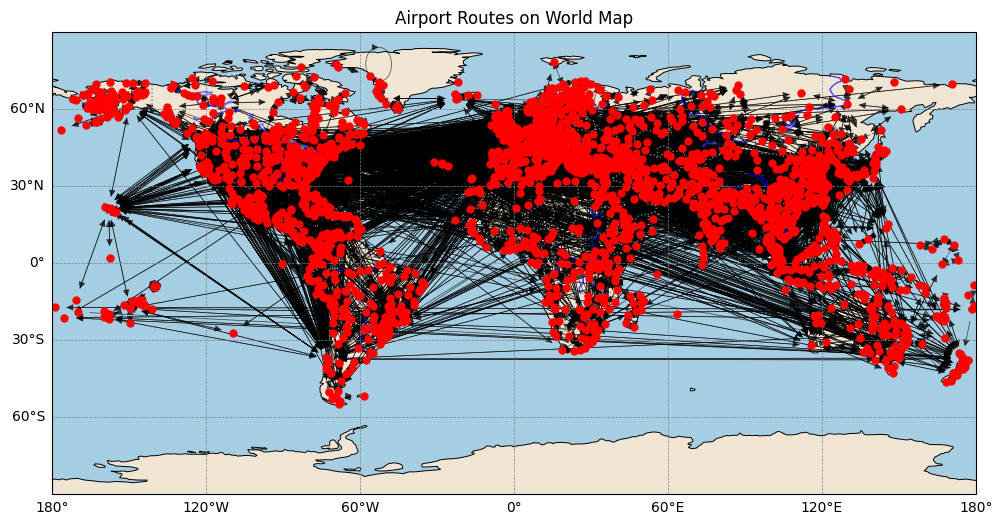

In [105]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import natural_earth

positions = {node: data['coords'] for node, data in G_loaded.nodes(data=True)}

# Set up the map using Cartopy
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Enhanced map styling
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add detailed features
ax.add_feature(cfeature.LAND, facecolor="#f0e4d3")  # Light beige for land
ax.add_feature(cfeature.OCEAN, facecolor="#a6cee3")  # Light blue for oceans
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.LAKES, facecolor="#a6cee3", edgecolor="blue", alpha=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.7)

# Optionally, add gridlines
gridlines = ax.gridlines(draw_labels=True, color="gray", linestyle="--", linewidth=0.5)
gridlines.top_labels = False
gridlines.right_labels = False

# Draw the graph
nx.draw_networkx_edges(G_loaded, positions, ax=ax, edge_color='black', alpha=0.7, width=0.5)
nx.draw_networkx_nodes(G_loaded, positions, ax=ax, node_size=25, node_color='red')

# Show the plot
plt.title("Airport Routes on World Map")
plt.show()